In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
import numpy as np 
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

from sklearn.pipeline import Pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import f1_score as calculate_f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Utilities

In [3]:
## utilities
# from utils import clean_text

import string
from sklearn.base import TransformerMixin

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')


def clean_text(text: str, lemmatizer = lambda x: x) -> str:
    # removes upper cases
    text = text.lower().strip()
    
    # removes punctuation
    for char in string.punctuation:
        text = text.replace(char, " ")
    
    #lematize the words and join back into string text
    text = " ".join([lemmatizer(word) for word in word_tokenize(text)])
    return text


def data_isvalid(text, analyser, min_character_size, max_character_size):
    return min_character_size <= len(analyser(text)) <= max_character_size


def get_lemmatizer():
#     return lambda x: x
    return WordNetLemmatizer().lemmatize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### load dataset

In [5]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
categories = all_docs.target_names

In [6]:
print(all_docs.data[0])



I think that domestication will change behavior to a large degree.
Domesticated animals exhibit behaviors not found in the wild.  I
don't think that they can be viewed as good representatives of the
wild animal kingdom, since they have been bred for thousands of years
to produce certain behaviors, etc.


## Create Dataframe

In [7]:
featuresdf = pd.DataFrame(
    data={
        "text":all_docs.data, 
        "class_label":all_docs.target
    }
)
labels = np.unique(featuresdf.class_label)

featuresdf.head()

,text,class_label
0,\n\nI think that domestication will change beh...,0
1,"\nI don't like this comment about ""Typical"" th...",3
2,\n<apparently you're not a woman - my husband ...,1
3,"While not exactly a service incident, I had a ...",1
4,\n\nI think I can. Largely as a result of effo...,2


### Label Frequency

1    594
2    593
3    564
0    480
Name: class_label, dtype: int64



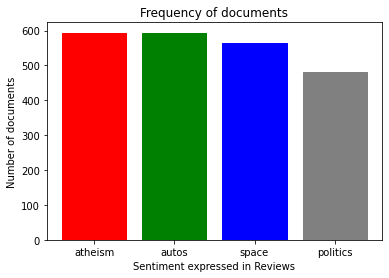

In [8]:
print(featuresdf["class_label"].value_counts())
print()

barlist = plt.bar(categories, featuresdf["class_label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

# Select Valid Data

In [9]:
max_size_per_class = 500

# remove long text
min_chr_size = 128
max_chr_size = 256
indices = featuresdf["text"].apply(data_isvalid, args=(lambda x: clean_text(x, get_lemmatizer()), min_chr_size, max_chr_size))
featuresdf = featuresdf[indices]

# make classes balanced
class_indices = []

for index in range(4):
    class_indices.append(np.where((featuresdf["class_label"] == index))[0])
    
size_per_class = min(max_size_per_class, min(map(len, class_indices)))
indices = np.concatenate([class_ids[:size_per_class] for class_ids in class_indices])

featuresdf = featuresdf.iloc[indices]

featuresdf.head()

,text,class_label
19,"\n\n\tI agree, we spend too much energy on the...",0
50,\n\n Could you explain what any of the above p...,0
164,\nUh oh. This looks a bit too much like Bobby...,0
178,\n\nI'd have to say that I have a problem with...,0
197,"\nWell, that explains some things; I posted on...",0


In [10]:
print(featuresdf.iloc[0]["text"])



	I agree, we spend too much energy on the nonexistance of God.

--


       "Satan and the Angels do not have freewill.  
        They do what god tells them to do. "


3    66
2    66
1    66
0    66
Name: class_label, dtype: int64



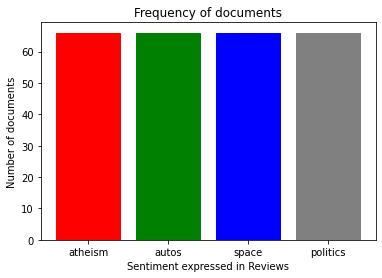

In [11]:
print(featuresdf["class_label"].value_counts())
print()

barlist = plt.bar(categories, featuresdf["class_label"].value_counts())

plt.title("Frequency of documents")
plt.xticks(categories, list(map(lambda x: x.split(".")[1], categories)))
plt.ylabel('Number of documents')
plt.xlabel('Sentiment expressed in Reviews')

barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('grey')
plt.show()

### Clean Input

In [12]:
featuresdf["text"] = featuresdf["text"].apply(lambda x: clean_text(x, get_lemmatizer()))

### Extract features

In [35]:
min_df = 3
stop_words = "english"

vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=min_df)

input_data = vectorizer.fit_transform(featuresdf["text"]).toarray()
output_labels = np.array(featuresdf["class_label"].tolist())

In [36]:
# featuresdf.feature = featuresdf.feature.apply(lambda xx: xx.reshape((4096, 2)))
print(input_data[0].shape)

(338,)


In [37]:
from itertools import combinations
from math import factorial

def number_of_combinations(n, r):
    return int(factorial(n) / (factorial(n - r) * factorial(r)))

def prepare_data_pair(X, y, labels):
    data = [[], []]
    
    for label in labels:
        indices = np.array(list(range(len(y))))
        similar_indices = indices[y == label]
        
        if len(similar_indices) < 2:
            continue
        
        for i, j in combinations(similar_indices, 2):
            for index, value in enumerate([i, j]):
                data[index].append(X[value])
            
        print(y[i], y[j])
    
    data = np.array(data)
    return data

In [38]:
labels

array([0, 1, 2, 3], dtype=int64)

In [61]:
# split the dataset 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# split train and test data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=100)
for train_index, test_index in sss.split(input_data, output_labels):
    x_train, x_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_labels[train_index], output_labels[test_index]

# prepare data set pairs
x_train_pair = prepare_data_pair(x_train, y_train, labels)

0 0
1 1
2 2
3 3


In [62]:
x_train.shape, y_train.shape

((198, 338), (198,))

In [63]:
x_test.shape, y_test.shape

((66, 338), (66,))

In [64]:
x_train_pair.shape

(2, 4802, 338)

### Convolutional Neural Network (CNN) model architecture 

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [66]:
latent_dim = 2

In [67]:
encoder_inputs = keras.Input(shape=(x_train.shape[1],))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 338)]        0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 256)          86784       input_12[0][0]                   
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 256)          0           dense_41[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 256)          65792       dropout_29[0][0]                 
____________________________________________________________________________________________

In [68]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128)(latent_inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(x_train.shape[1], activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               384       
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0   

### Compiling the model 

For compiling our model, we will use the same three parameters as the previous model: 

In [69]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit([x_train], epochs=30, batch_size=128)

Epoch 1/30
2/2 [==============================] - 1s 9ms/step - loss: 9.6124 - reconstruction_loss: 8.6875 - kl_loss: 0.0052
Epoch 2/30
2/2 [==============================] - 0s 9ms/step - loss: 9.4801 - reconstruction_loss: 8.6682 - kl_loss: 0.0277
Epoch 3/30
2/2 [==============================] - 0s 14ms/step - loss: 9.4794 - reconstruction_loss: 8.5747 - kl_loss: 0.0459
Epoch 4/30
2/2 [==============================] - 0s 8ms/step - loss: 9.4819 - reconstruction_loss: 8.5883 - kl_loss: 0.0562
Epoch 5/30
2/2 [==============================] - 0s 8ms/step - loss: 9.6478 - reconstruction_loss: 8.6036 - kl_loss: 0.0550
Epoch 6/30
2/2 [==============================] - 0s 8ms/step - loss: 9.5573 - reconstruction_loss: 8.6384 - kl_loss: 0.0514
Epoch 7/30
2/2 [==============================] - 0s 11ms/step - loss: 9.4995 - reconstruction_loss: 8.5248 - kl_loss: 0.0535
Epoch 8/30
2/2 [==============================] - 0s 9ms/step - loss: 9.5012 - reconstruction_loss: 8.6061 - kl_loss: 0.073

In [70]:
# Display model architecture summary 
# vae.summary()

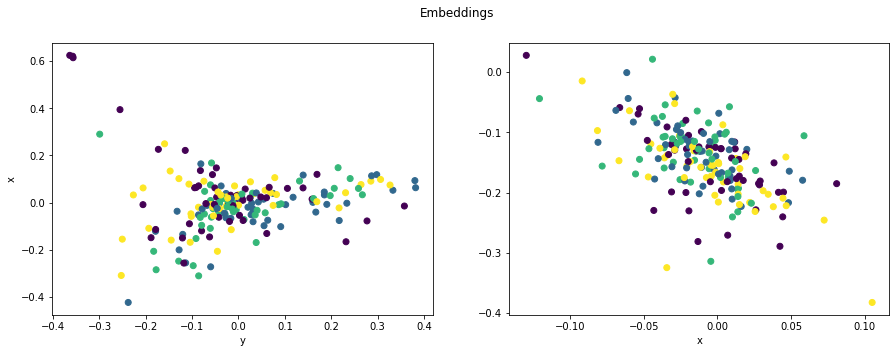

In [76]:
from sklearn.decomposition import PCA

def plot_label_clusters(vae, data, labels, pca=None):
    # display a 2D plot of the digit classes in the latent space
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Embeddings')
    fig.set_figwidth(15)
    fig.set_figheight(5)
    
    if not pca:
        pca = PCA(n_components=2)
        pca.fit(data[0])
        
    z = pca.transform(data[0])
    ax1.scatter(z[:, 0], z[:, 1], c=labels)
    ax1.set_xlabel("y")
    ax1.set_ylabel("x")
        
    z_mean, _, _ = vae.encoder.predict(data)
    ax2.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    ax2.set_xlabel("x")

    plt.show()

plot_label_clusters(vae, [x_train], y_train)

In [46]:
# load weights
# model.load_weights("saved_models/weights.cnn.best.hdf5")

#### Evaluation

### Best freq treshold

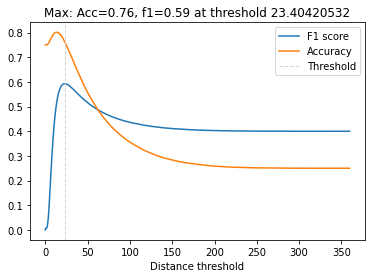

In [47]:
from sklearn.metrics import f1_score, accuracy_score

def get_eval_params(data_input, data_labels):
    pairs = []
    distances = [] # squared L2 distance between pairs
    identical = [] # 1 if same identity, 0 otherwise

    num = len(data_input)
    embedded = model.layers[3].predict(data_input)

    for i in range(num):
        for j in range(num):
            pairs.append([embedded[i], embedded[j]])
            distances.append(distance(embedded[i], embedded[j]))
            identical.append(1 if data_labels[i] == data_labels[j] else 0)
            
    pairs = np.array(pairs)
    distances = np.array(distances)
    identical = np.array(identical)
    
    return pairs, distances, identical, embedded

train_pairs, train_distances, train_identical, train_embedded = get_eval_params(x_train, y_train)
test_pairs, test_distances, test_identical, test_embedded = get_eval_params(x_test, y_test)

min_threshold = min(train_distances)
max_threshold = max(train_distances)
threshold_step = (max_threshold - min_threshold)/1000
thresholds = np.arange(min_threshold, max_threshold, threshold_step)

f1_scores = [f1_score(train_identical, train_distances < t) for t in thresholds]
acc_scores = [accuracy_score(train_identical, train_distances < t) for t in thresholds]

# max f1
opt_idx = np.argmax(f1_scores)
opt_f1 = np.max(f1_scores)

# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]

# Accuracy at maximal F1 score
opt_acc = accuracy_score(train_identical, train_distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Max: Acc={opt_acc:.2f}, f1={opt_f1:.2f} at threshold {opt_tau:.8f}');
plt.xlabel('Distance threshold')
plt.legend();

In [48]:
train_distances.shape, train_pairs.shape, train_identical.shape

((1205604,), (1205604, 2, 128), (1205604,))

In [49]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

prediction = test_distances < opt_tau

print("accuracy =", accuracy_score(test_identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(test_identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(test_identical, prediction))

accuracy = 0.6584699453551912

classification_report
              precision    recall  f1-score   support

           0       0.85      0.67      0.75    100466
           1       0.39      0.63      0.48     33490

    accuracy                           0.66    133956
   macro avg       0.62      0.65      0.61    133956
weighted avg       0.73      0.66      0.68    133956


confusion matrix
[[66982 33484]
 [12266 21224]]


### Testing Evaluation

In [90]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

le.classes_

array(['1A', '1B', '1D', '1EH', '1EL', '1G'], dtype='<U3')

In [91]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

using_distance = True

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto'))
# clf = make_pipeline(StandardScaler(), LogisticRegression(multi_class="ovr", random_state=0, max_iter=128))

if using_distance:
    xx_train, yy_train = train_distances.reshape(-1, 1), train_identical
    xx_test, yy_test = test_distances.reshape(-1, 1), test_identical

else:
    xx_train, yy_train = train_embedded, y_train_le
    xx_test, yy_test = test_embedded, y_test_le

clf.fit(xx_train, yy_train)
print(f"training accuracy = {clf.score(xx_train, yy_train):.2f}")

training accuracy = 0.97


In [92]:
xx_train.shape, yy_train.shape

((8836, 1), (8836,))

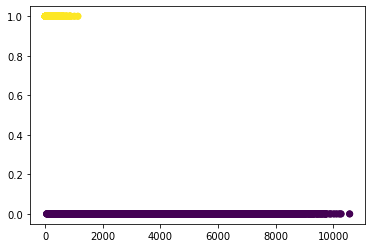

In [93]:
if using_distance:
    plt.scatter(xx_train, yy_train, c=yy_train)

In [94]:
print(f"test accuracy = {clf.score(xx_test, yy_test):.2f}")

test accuracy = 0.94


In [95]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(xx_test)
confusion_matrix(yy_test, y_pred)

array([[436,  32],
       [  4, 104]], dtype=int64)

In [96]:
np.unique(yy_test), np.unique(y_pred)

(array([0, 1]), array([0, 1]))

In [97]:
from sklearn.metrics import classification_report

print(classification_report(yy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       468
           1       0.76      0.96      0.85       108

    accuracy                           0.94       576
   macro avg       0.88      0.95      0.91       576
weighted avg       0.95      0.94      0.94       576



### Testing (new data) Evaluation

In [98]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["EH", "D", "A", "B", "G", "EL"]
# sample_dirs = ["A"]

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join("data", "old_guitar_sample", label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join("data", "old_guitar_sample", label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append("1"+label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

EH, D, A, B, G, EL, 

(58, 40, 256, 1)


In [99]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise
prediction = []

num = len(x_test_sample)
print(x_test_sample.shape)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    for j in range(num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if y_test_sample[i] == y_test_sample[j] else 0)
        prediction.append(1 if distances[-1] < opt_tau else 0)
        
distances = np.array(distances)
identical = np.array(identical)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

(58, 40, 256, 1)
accuracy = 0.8632580261593341

classification_report
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2802
           1       0.55      0.94      0.70       562

    accuracy                           0.86      3364
   macro avg       0.77      0.89      0.80      3364
weighted avg       0.91      0.86      0.88      3364


confusion matrix
[[2378  424]
 [  36  526]]


In [100]:
if using_distance:
    x_test_sample, y_test_sample = distances.reshape(-1, 1), identical

else:
    x_test_sample, y_test_sample = embedded, le.transform(y_test_sample)

In [101]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.86


In [102]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[2360,  442],
       [  36,  526]], dtype=int64)

In [103]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2802
           1       0.54      0.94      0.69       562

    accuracy                           0.86      3364
   macro avg       0.76      0.89      0.80      3364
weighted avg       0.91      0.86      0.87      3364



### Testing (sample) Evaluation

In [104]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["1EH", "1D", "1A", "1B", "1G", "1EL"]

sample_label = "1A"
sample_filepath = os.path.join("data", "sampleA.wav")
sample_vector = extract_features(sample_filepath)
sample_vector = np.expand_dims(np.expand_dims(sample_vector, axis=-1), axis=0)
sample_embedded = model.layers[3].predict(sample_vector)

for label in tqdm(sample_dirs):
    print(label, end=", ")
    labeldir= os.path.join(DATA_DIR, label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join(DATA_DIR, label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        anchor_file_vector = np.expand_dims(anchor_file_vector, axis=-1)
        x_test_sample.append(anchor_file_vector)
        y_test_sample.append(label)

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

1EH, 1D, 1A, 1B, 1G, 1EL, 

(118, 40, 256, 1)


In [105]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

identical = []
distances = [] # squared L2 distance between pairs
prediction = []

num = len(x_test_sample)
embedded = model.layers[3].predict(x_test_sample)

for i in range(num):
    identical.append(1 if sample_label == y_test_sample[i] else 0)
    distances.append(distance(embedded[i], sample_embedded))
    prediction.append(1 if distances[-1] < opt_tau else 0)

identical = np.array(identical)
distances = np.array(distances)
prediction = np.array(prediction)

print("accuracy =", accuracy_score(identical, prediction))

print("\nclassification_report")
print("========================")
print(classification_report(identical, prediction))

print("\nconfusion matrix")
print("========================")
print(confusion_matrix(identical, prediction))

accuracy = 0.711864406779661

classification_report
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        98
           1       0.00      0.00      0.00        20

    accuracy                           0.71       118
   macro avg       0.40      0.43      0.42       118
weighted avg       0.67      0.71      0.69       118


confusion matrix
[[84 14]
 [20  0]]


In [106]:
if using_distance:
    x_test_sample, y_test_sample = distances.reshape(-1, 1), identical

else:
    x_test_sample, y_test_sample = sample_embedded, le.transform([sample_label])

In [107]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.70


In [108]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[83, 15],
       [20,  0]], dtype=int64)

In [109]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        98
           1       0.00      0.00      0.00        20

    accuracy                           0.70       118
   macro avg       0.40      0.42      0.41       118
weighted avg       0.67      0.70      0.69       118

